# Moments Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the moments optimization results from split migration experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Set Up Data Paths

Define paths to the experiment directories containing simulations and results.

In [2]:
# Define base paths
base_path = Path('/home/akapoor/kernlab/Infer_Demography/experiments/split_migration')
simulations_path = base_path / 'simulations'
runs_path = base_path / 'runs'

print(f"Base path: {base_path}")
print(f"Simulations path: {simulations_path}")
print(f"Runs path: {runs_path}")

# Check if paths exist
print(f"\nPaths exist:")
print(f"Simulations: {simulations_path.exists()}")
print(f"Runs: {runs_path.exists()}")

# Check moments results structure
sample_moments_dir = runs_path / 'run_0_0' / 'inferences' / 'moments'
if sample_moments_dir.exists():
    print(f"\nSample moments directory contents:")
    for f in sample_moments_dir.glob('*'):
        print(f"  {f.name}")
else:
    print(f"\nSample moments directory not found: {sample_moments_dir}")

Base path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration
Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/simulations
Runs path: /home/akapoor/kernlab/Infer_Demography/experiments/split_migration/runs

Paths exist:
Simulations: True
Runs: True

Sample moments directory contents:
  profiles_grid.png
  fit_params.pkl
  best_fit.pkl


## Load Simulation Data and Ground Truth

Read ground truth parameter values from the simulations directory structure.

In [3]:
def load_ground_truth_parameters():
    """Load ground truth parameters from simulation directories."""
    ground_truth = {}
    
    # Iterate through simulation directories (0-9)
    for sim_dir in sorted(simulations_path.glob('*')):
        if sim_dir.is_dir():
            sim_id = sim_dir.name
            param_file = sim_dir / 'sampled_params.pkl'
            
            if param_file.exists():
                try:
                    with open(param_file, 'rb') as f:
                        params = pickle.load(f)
                    ground_truth[sim_id] = params
                    print(f"Loaded ground truth for simulation {sim_id}")
                except Exception as e:
                    print(f"Error loading {param_file}: {e}")
            else:
                print(f"Parameter file not found: {param_file}")
    
    return ground_truth

# Load ground truth parameters
ground_truth_params = load_ground_truth_parameters()

# Display structure of ground truth data
if ground_truth_params:
    first_sim = list(ground_truth_params.keys())[0]
    print(f"\nExample parameters for simulation {first_sim}:")
    for key, value in ground_truth_params[first_sim].items():
        print(f"  {key}: {value}")
else:
    print("No ground truth parameters loaded!")

Loaded ground truth for simulation 0
Loaded ground truth for simulation 1
Loaded ground truth for simulation 2
Loaded ground truth for simulation 3
Loaded ground truth for simulation 4
Loaded ground truth for simulation 5
Loaded ground truth for simulation 6
Loaded ground truth for simulation 7
Loaded ground truth for simulation 8
Loaded ground truth for simulation 9

Example parameters for simulation 0:
  N0: 18501.631461064615
  N1: 16024.490572429595
  N2: 17308.87575718409
  m12: 4.572833570938417e-05
  m21: 8.50077191064645e-05
  t_split: 11491.501585812743


## Load Moments Best Fit Results

Load the moments optimization results for each run, including parameter estimates and likelihood values.

In [4]:
def load_moments_results():
    """Load moments best fit results from run directories."""
    moments_results = {}
    
    # Search for moments result files in run directories
    run_dirs = sorted(runs_path.glob('run_*_*'))
    
    print(f"Found {len(run_dirs)} run directories")
    
    for run_dir in run_dirs:
        if run_dir.is_dir():
            run_name = run_dir.name
            moments_dir = run_dir / 'inferences' / 'moments'
            
            if not moments_dir.exists():
                continue
                
            # Look for moments output files
            possible_files = [
                moments_dir / 'best_fit.pkl',
                moments_dir / 'fit_params.pkl',
                moments_dir / 'optimization_results.pkl',
                moments_dir / 'moments_results.pkl',
                moments_dir / 'results.pkl'
            ]
            
            result_data = {}
            
            # Try to load all available result files
            for result_file in possible_files:
                if result_file.exists():
                    try:
                        with open(result_file, 'rb') as f:
                            data = pickle.load(f)
                        result_data[result_file.name] = data
                    except Exception as e:
                        print(f"Error loading {result_file}: {e}")
            
            if result_data:
                # Parse run name to get simulation and replicate info
                # Assuming format: run_sim_rep (e.g., run_0_1)
                parts = run_name.split('_')
                if len(parts) >= 3:
                    sim_id = parts[1]
                    rep_id = parts[2]
                    
                    if sim_id not in moments_results:
                        moments_results[sim_id] = {}
                    
                    moments_results[sim_id][rep_id] = {
                        'results': result_data,
                        'directory': moments_dir
                    }
    
    return moments_results

# Load moments results
moments_results = load_moments_results()

# Display summary of loaded results
print(f"\nLoaded moments results for {len(moments_results)} simulations:")
for sim_id, sim_results in moments_results.items():
    print(f"  Simulation {sim_id}: {len(sim_results)} replicates")

# Show structure of first result if available
if moments_results:
    first_sim = list(moments_results.keys())[0]
    first_rep = list(moments_results[first_sim].keys())[0]
    first_result = moments_results[first_sim][first_rep]['results']
    print(f"\nExample result structure for sim {first_sim}, rep {first_rep}:")
    for file_name, data in first_result.items():
        print(f"  {file_name}: {type(data)}")
        if isinstance(data, dict):
            print(f"    Keys: {list(data.keys())[:5]}")
        elif hasattr(data, 'shape'):
            print(f"    Shape: {data.shape}")

Found 100 run directories

Loaded moments results for 10 simulations:
  Simulation 0: 10 replicates
  Simulation 1: 10 replicates
  Simulation 2: 10 replicates
  Simulation 3: 10 replicates
  Simulation 4: 10 replicates
  Simulation 5: 10 replicates
  Simulation 6: 10 replicates
  Simulation 7: 10 replicates
  Simulation 8: 10 replicates
  Simulation 9: 10 replicates

Example result structure for sim 0, rep 0:
  best_fit.pkl: <class 'dict'>
    Keys: ['mode', 'best_params', 'best_ll', 'status', 'param_order']
  fit_params.pkl: <class 'dict'>
    Keys: ['mode', 'best_params', 'best_ll', 'status', 'param_order']


## Explore Moments Data Structure

Let's examine the actual file structure to understand how the moments data is organized.

In [5]:
# Let's explore the actual moments results structure
print("Examining moments results structure...")

# Check a few moments directories to see what files they contain
sample_runs = list(runs_path.glob('run_*_*'))[:3]

for run_dir in sample_runs:
    moments_dir = run_dir / 'inferences' / 'moments'
    if moments_dir.exists():
        print(f"\n{run_dir.name}/inferences/moments:")
        files = sorted(moments_dir.glob('*'))
        for f in files:
            if f.is_file():
                size = f.stat().st_size
                print(f"  {f.name} ({size} bytes)")
            else:
                print(f"  {f.name}/ (directory)")

# Let's examine the content of one of the pickle files to understand the structure
if moments_results:
    first_sim = list(moments_results.keys())[0]
    first_rep = list(moments_results[first_sim].keys())[0]
    result_files = moments_results[first_sim][first_rep]['results']
    
    print(f"\n\nDetailed examination of results for sim {first_sim}, rep {first_rep}:")
    print("=" * 60)
    
    for file_name, data in result_files.items():
        print(f"\n{file_name}:")
        print(f"  Type: {type(data)}")
        
        if isinstance(data, dict):
            print(f"  Keys: {list(data.keys())}")
            for key, value in data.items():
                if isinstance(value, (int, float, str)):
                    print(f"    {key}: {value}")
                elif hasattr(value, 'shape'):
                    print(f"    {key}: {type(value)} with shape {value.shape}")
                else:
                    print(f"    {key}: {type(value)}")
        
        elif isinstance(data, (list, tuple)):
            print(f"  Length: {len(data)}")
            if len(data) > 0:
                print(f"  First element: {data[0]} (type: {type(data[0])})")
        
        elif hasattr(data, 'shape'):
            print(f"  Shape: {data.shape}")
            if data.size < 20:
                print(f"  Values: {data}")

Examining moments results structure...

run_8_5/inferences/moments:
  best_fit.pkl (249 bytes)
  fit_params.pkl (249 bytes)
  profiles_grid.png (139742 bytes)

run_3_5/inferences/moments:
  best_fit.pkl (249 bytes)
  fit_params.pkl (249 bytes)
  profiles_grid.png (123922 bytes)

run_1_4/inferences/moments:
  best_fit.pkl (249 bytes)
  fit_params.pkl (249 bytes)
  profiles_grid.png (120350 bytes)


Detailed examination of results for sim 0, rep 0:

best_fit.pkl:
  Type: <class 'dict'>
  Keys: ['mode', 'best_params', 'best_ll', 'status', 'param_order', 'fixed_params', 'sampled_demes']
    mode: moments
    best_params: <class 'dict'>
    best_ll: 349895.68686777283
    status: 3
    param_order: <class 'list'>
    fixed_params: <class 'dict'>
    sampled_demes: <class 'list'>

fit_params.pkl:
  Type: <class 'dict'>
  Keys: ['mode', 'best_params', 'best_ll', 'status', 'param_order', 'fixed_params', 'sampled_demes']
    mode: moments
    best_params: <class 'dict'>
    best_ll: 349895.6868

## Create Data Processing Functions for Moments

Based on the actual file structure, create functions to extract parameters from moments results.

In [6]:
def extract_moments_parameters(results_data):
    """Extract parameter values from moments results data structure."""
    params = {}
    likelihood = None
    
    # Try to extract from different file types
    for file_name, data in results_data.items():
        
        if file_name == 'best_fit.pkl':
            # Handle best_fit.pkl structure
            if isinstance(data, dict):
                # Look for parameter keys
                param_keys = ['best_params', 'optimal_params', 'parameters', 'params']
                for key in param_keys:
                    if key in data:
                        if isinstance(data[key], dict):
                            params.update(data[key])
                        elif isinstance(data[key], (list, tuple, np.ndarray)):
                            # Map to parameter names (adjust based on your model)
                            param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                            if len(data[key]) <= len(param_names):
                                params.update(dict(zip(param_names[:len(data[key])], data[key])))
                        break
                
                # Look for likelihood
                ll_keys = ['best_lls', 'likelihood', 'll', 'log_likelihood', 'best_ll']
                for key in ll_keys:
                    if key in data:
                        likelihood = data[key]
                        break
            
            elif isinstance(data, (list, tuple, np.ndarray)):
                # If best_fit.pkl contains just parameter values
                param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                if len(data) <= len(param_names):
                    params = dict(zip(param_names[:len(data)], data))
        
        elif file_name == 'fit_params.pkl':
            # Handle fit_params.pkl structure
            if isinstance(data, dict):
                params.update(data)
            elif isinstance(data, (list, tuple, np.ndarray)):
                param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                if len(data) <= len(param_names):
                    params.update(dict(zip(param_names[:len(data)], data)))
    
    # Add likelihood to params if found
    if likelihood is not None:
        params['log_likelihood'] = likelihood
    
    return params

def create_moments_comparison_dataframe(ground_truth_params, moments_results):
    """Create a DataFrame comparing ground truth vs estimated parameters for moments."""
    comparison_data = []
    
    for sim_id in ground_truth_params.keys():
        if sim_id in moments_results:
            gt_params = ground_truth_params[sim_id]
            
            for rep_id, rep_data in moments_results[sim_id].items():
                est_params = extract_moments_parameters(rep_data['results'])
                
                # Create a row for each parameter
                for param_name in gt_params.keys():
                    if param_name in est_params:
                        gt_val = gt_params[param_name]
                        est_val = est_params[param_name]
                        
                        comparison_data.append({
                            'simulation': sim_id,
                            'replicate': rep_id,
                            'parameter': param_name,
                            'ground_truth': gt_val,
                            'estimated': est_val,
                            'absolute_error': est_val - gt_val,
                            'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan
                        })
                
                # Add likelihood if available
                if 'log_likelihood' in est_params:
                    comparison_data.append({
                        'simulation': sim_id,
                        'replicate': rep_id,
                        'parameter': 'log_likelihood',
                        'ground_truth': np.nan,  # No ground truth for likelihood
                        'estimated': est_params['log_likelihood'],
                        'absolute_error': np.nan,
                        'relative_error': np.nan
                    })
    
    return pd.DataFrame(comparison_data)

# Try to create the comparison DataFrame
if ground_truth_params and moments_results:
    df_moments_comparison = create_moments_comparison_dataframe(ground_truth_params, moments_results)
    print(f"Created moments comparison DataFrame with {len(df_moments_comparison)} rows")
    
    if not df_moments_comparison.empty:
        print(f"Parameters found: {df_moments_comparison['parameter'].unique()}")
        print(f"Simulations: {sorted(df_moments_comparison['simulation'].unique())}")
        
        # Show sample of non-likelihood parameters
        sample_data = df_moments_comparison[df_moments_comparison['parameter'] != 'log_likelihood'].head(10)
        if not sample_data.empty:
            print(f"\nFirst few parameter comparisons:")
            print(sample_data[['simulation', 'replicate', 'parameter', 'ground_truth', 'estimated', 'relative_error']].round(4))
    else:
        print("DataFrame is empty - no matching parameters found")
else:
    print("Cannot create comparison DataFrame - missing ground truth or moments results")

Created moments comparison DataFrame with 700 rows
Parameters found: ['N0' 'N1' 'N2' 'm12' 'm21' 't_split' 'log_likelihood']
Simulations: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

First few parameter comparisons:
   simulation replicate parameter  ground_truth   estimated  relative_error
0           0         0        N0    18501.6315  18304.7898         -0.0106
1           0         0        N1    16024.4906  15504.2104         -0.0325
2           0         0        N2    17308.8758  16858.5003         -0.0260
3           0         0       m12        0.0000      0.0001          0.1655
4           0         0       m21        0.0001      0.0001          0.0804
5           0         0   t_split    11491.5016  12273.8775          0.0681
7           0         1        N0    18501.6315  18304.7898         -0.0106
8           0         1        N1    16024.4906  15504.2104         -0.0325
9           0         1        N2    17308.8758  16858.5003         -0.0260
10          0    

## Plot Best Fit vs Ground Truth Comparison for Moments

Create scatter plots comparing estimated parameters against true parameter values.

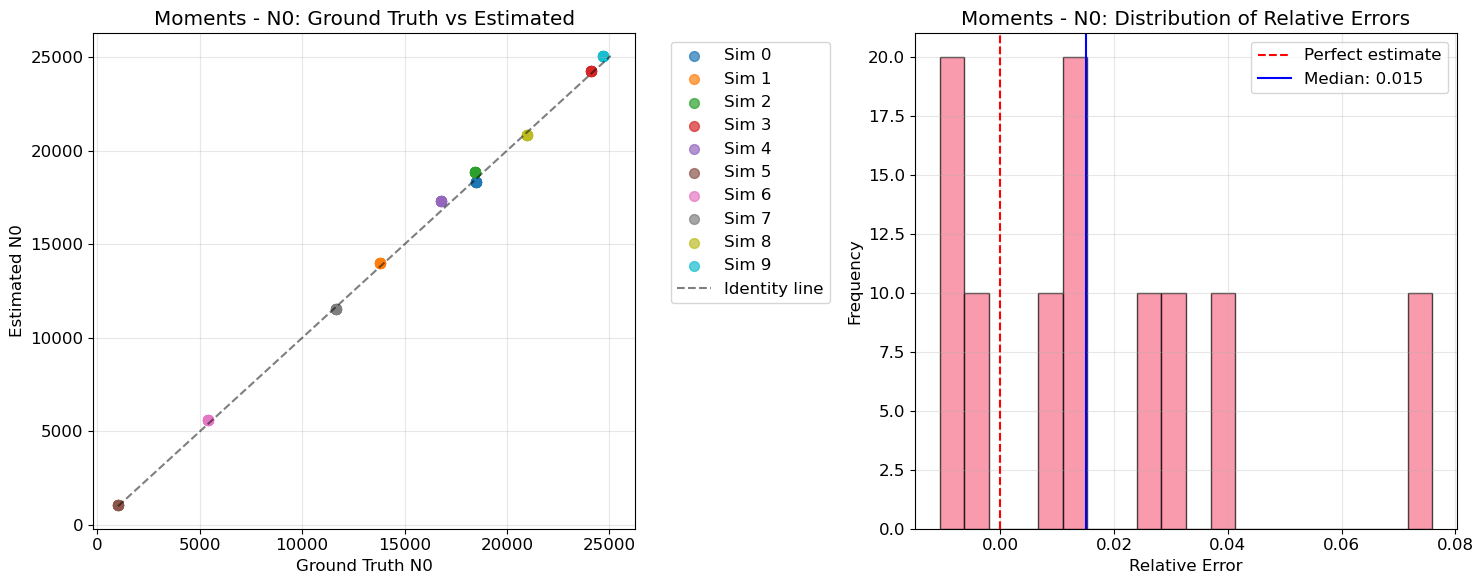


Moments Summary for N0:
  Mean relative error: 0.0185
  Median relative error: 0.0151
  Std relative error: 0.0249
  Correlation coefficient: 0.9995
  Number of estimates: 100


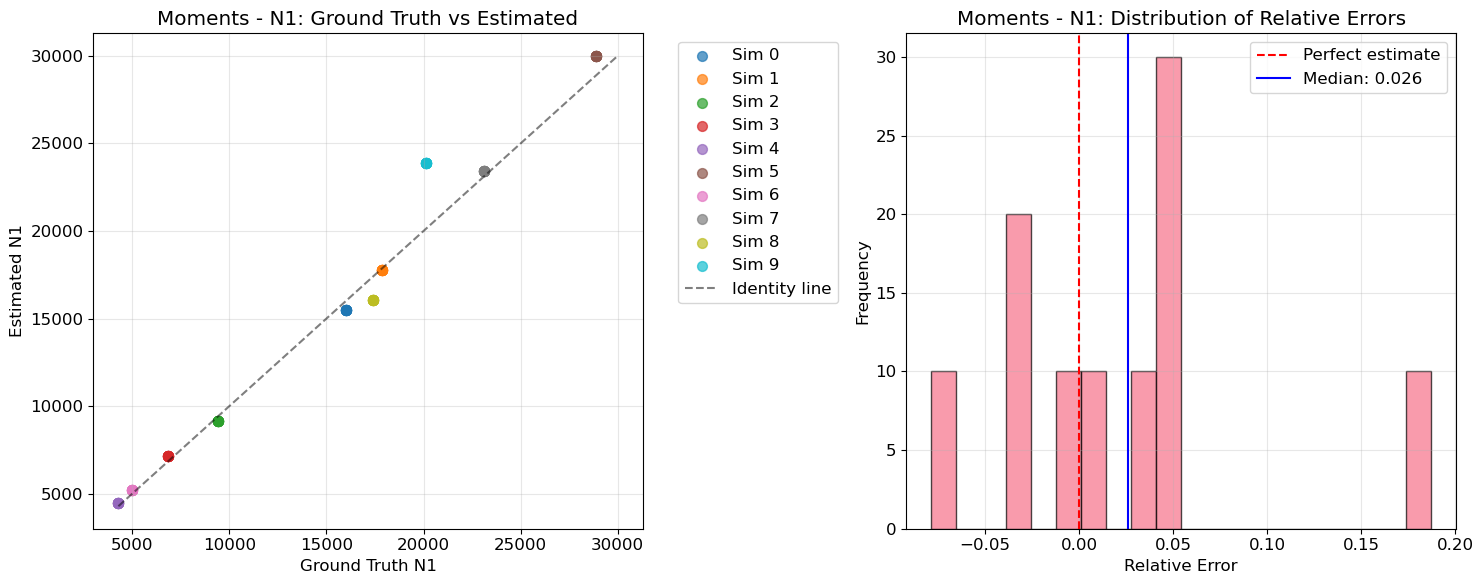


Moments Summary for N1:
  Mean relative error: 0.0220
  Median relative error: 0.0258
  Std relative error: 0.0674
  Correlation coefficient: 0.9889
  Number of estimates: 100


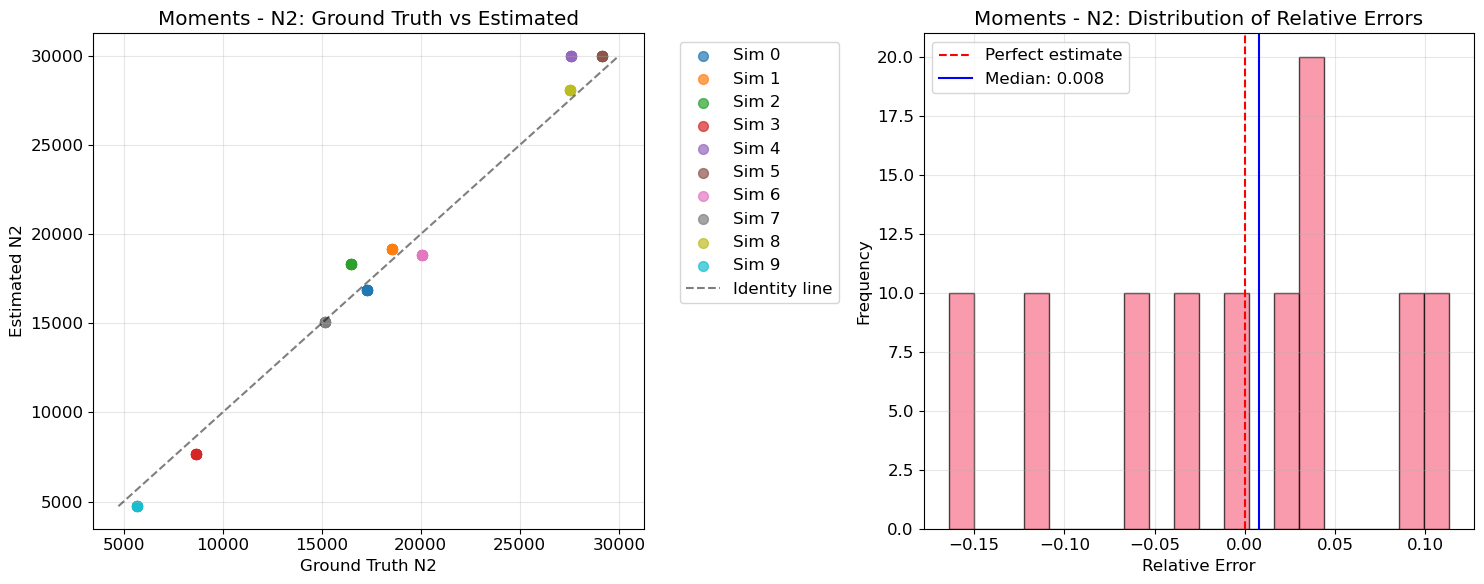


Moments Summary for N2:
  Mean relative error: -0.0088
  Median relative error: 0.0080
  Std relative error: 0.0822
  Correlation coefficient: 0.9936
  Number of estimates: 100


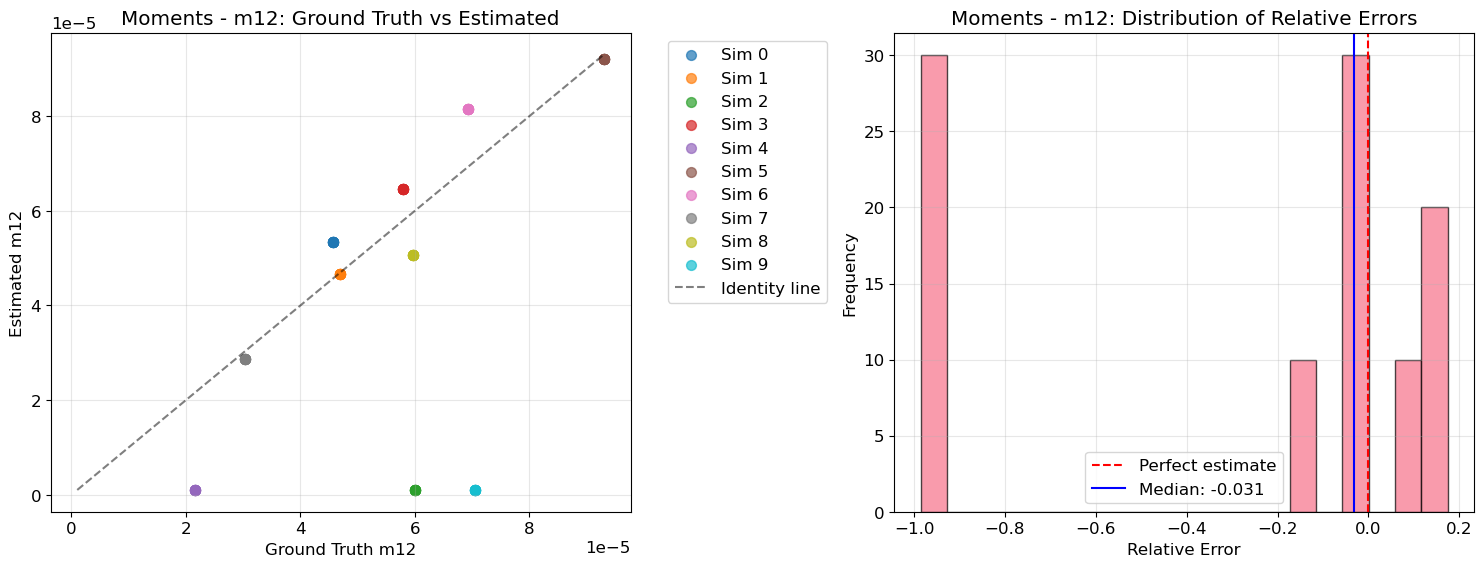


Moments Summary for m12:
  Mean relative error: -0.2684
  Median relative error: -0.0315
  Std relative error: 0.4737
  Correlation coefficient: 0.5319
  Number of estimates: 100


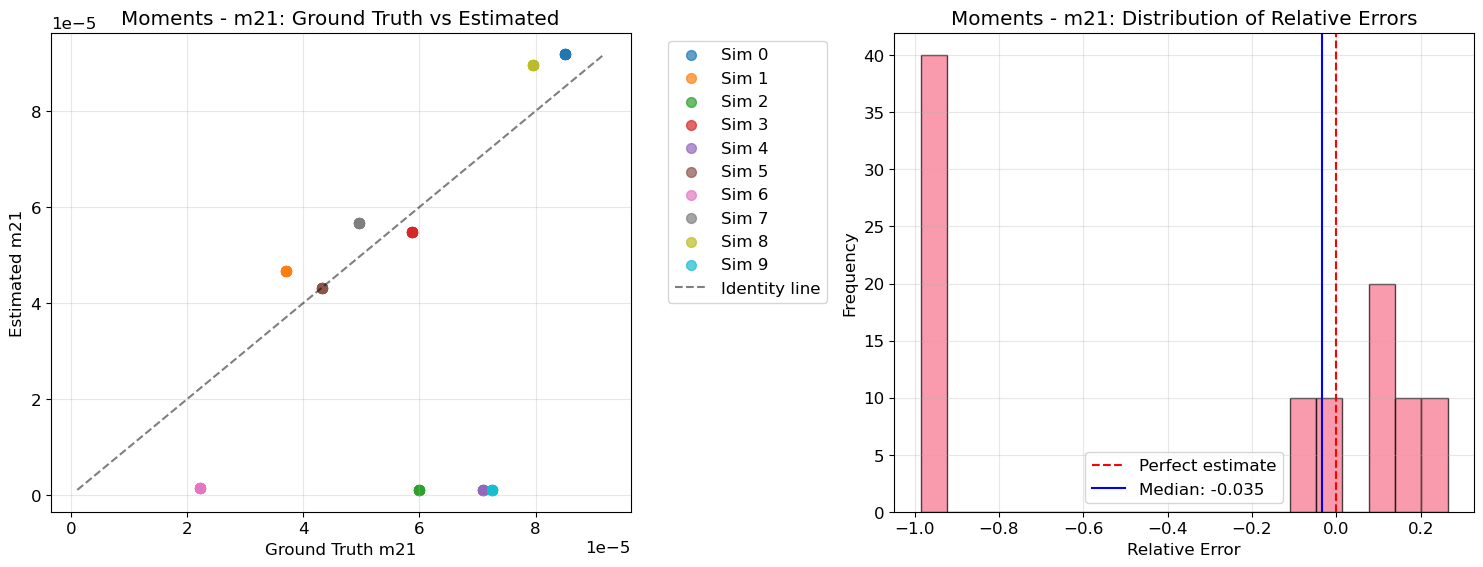


Moments Summary for m21:
  Mean relative error: -0.3338
  Median relative error: -0.0346
  Std relative error: 0.5296
  Correlation coefficient: 0.3675
  Number of estimates: 100


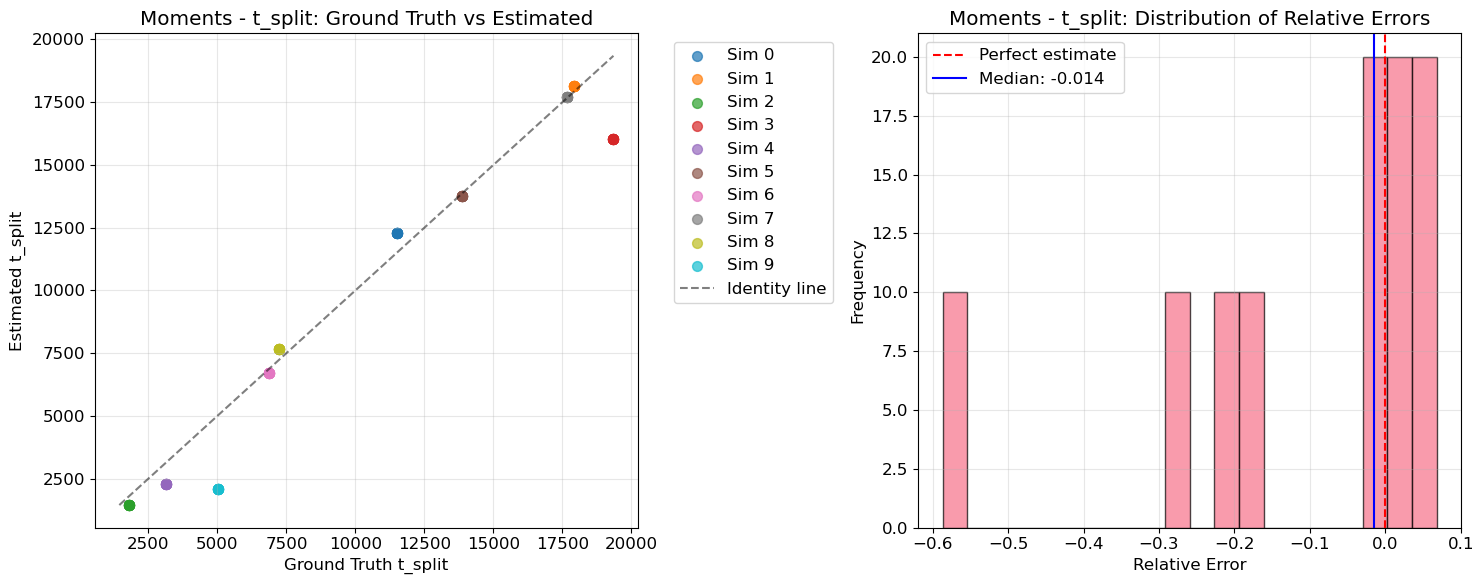


Moments Summary for t_split:
  Mean relative error: -0.1108
  Median relative error: -0.0144
  Std relative error: 0.1932
  Correlation coefficient: 0.9773
  Number of estimates: 100


In [7]:
def plot_moments_parameter_comparison(df, parameter_name):
    """Plot ground truth vs estimated values for a specific parameter (moments)."""
    param_data = df[(df['parameter'] == parameter_name) & (df['parameter'] != 'log_likelihood')]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Ground truth vs Estimated
    ax1 = axes[0]
    
    # Color by simulation
    colors = plt.cm.tab10(np.linspace(0, 1, len(param_data['simulation'].unique())))
    for i, sim_id in enumerate(sorted(param_data['simulation'].unique())):
        sim_data = param_data[param_data['simulation'] == sim_id]
        ax1.scatter(sim_data['ground_truth'], sim_data['estimated'], 
                   label=f'Sim {sim_id}', alpha=0.7, s=50, color=colors[i])
    
    # Add identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Identity line')
    
    ax1.set_xlabel(f'Ground Truth {parameter_name}')
    ax1.set_ylabel(f'Estimated {parameter_name}')
    ax1.set_title(f'Moments - {parameter_name}: Ground Truth vs Estimated')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Relative error histogram
    ax2 = axes[1]
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Moments - {parameter_name}: Distribution of Relative Errors')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated', 'relative_error'])
    if len(valid_data) > 0:
        correlation = valid_data['ground_truth'].corr(valid_data['estimated'])
        print(f"\nMoments Summary for {parameter_name}:")
        print(f"  Mean relative error: {valid_data['relative_error'].mean():.4f}")
        print(f"  Median relative error: {valid_data['relative_error'].median():.4f}")
        print(f"  Std relative error: {valid_data['relative_error'].std():.4f}")
        print(f"  Correlation coefficient: {correlation:.4f}")
        print(f"  Number of estimates: {len(valid_data)}")

# Plot comparisons for all parameters (excluding log_likelihood)
if 'df_moments_comparison' in locals() and not df_moments_comparison.empty:
    params_to_plot = [p for p in df_moments_comparison['parameter'].unique() if p != 'log_likelihood']
    
    for param in params_to_plot:
        plot_moments_parameter_comparison(df_moments_comparison, param)
else:
    print("No moments comparison data available for plotting")

## Create Parameter Histograms for Each Simulation (Moments)

Generate histograms showing the distribution of best fit parameters across replicates for each simulation.

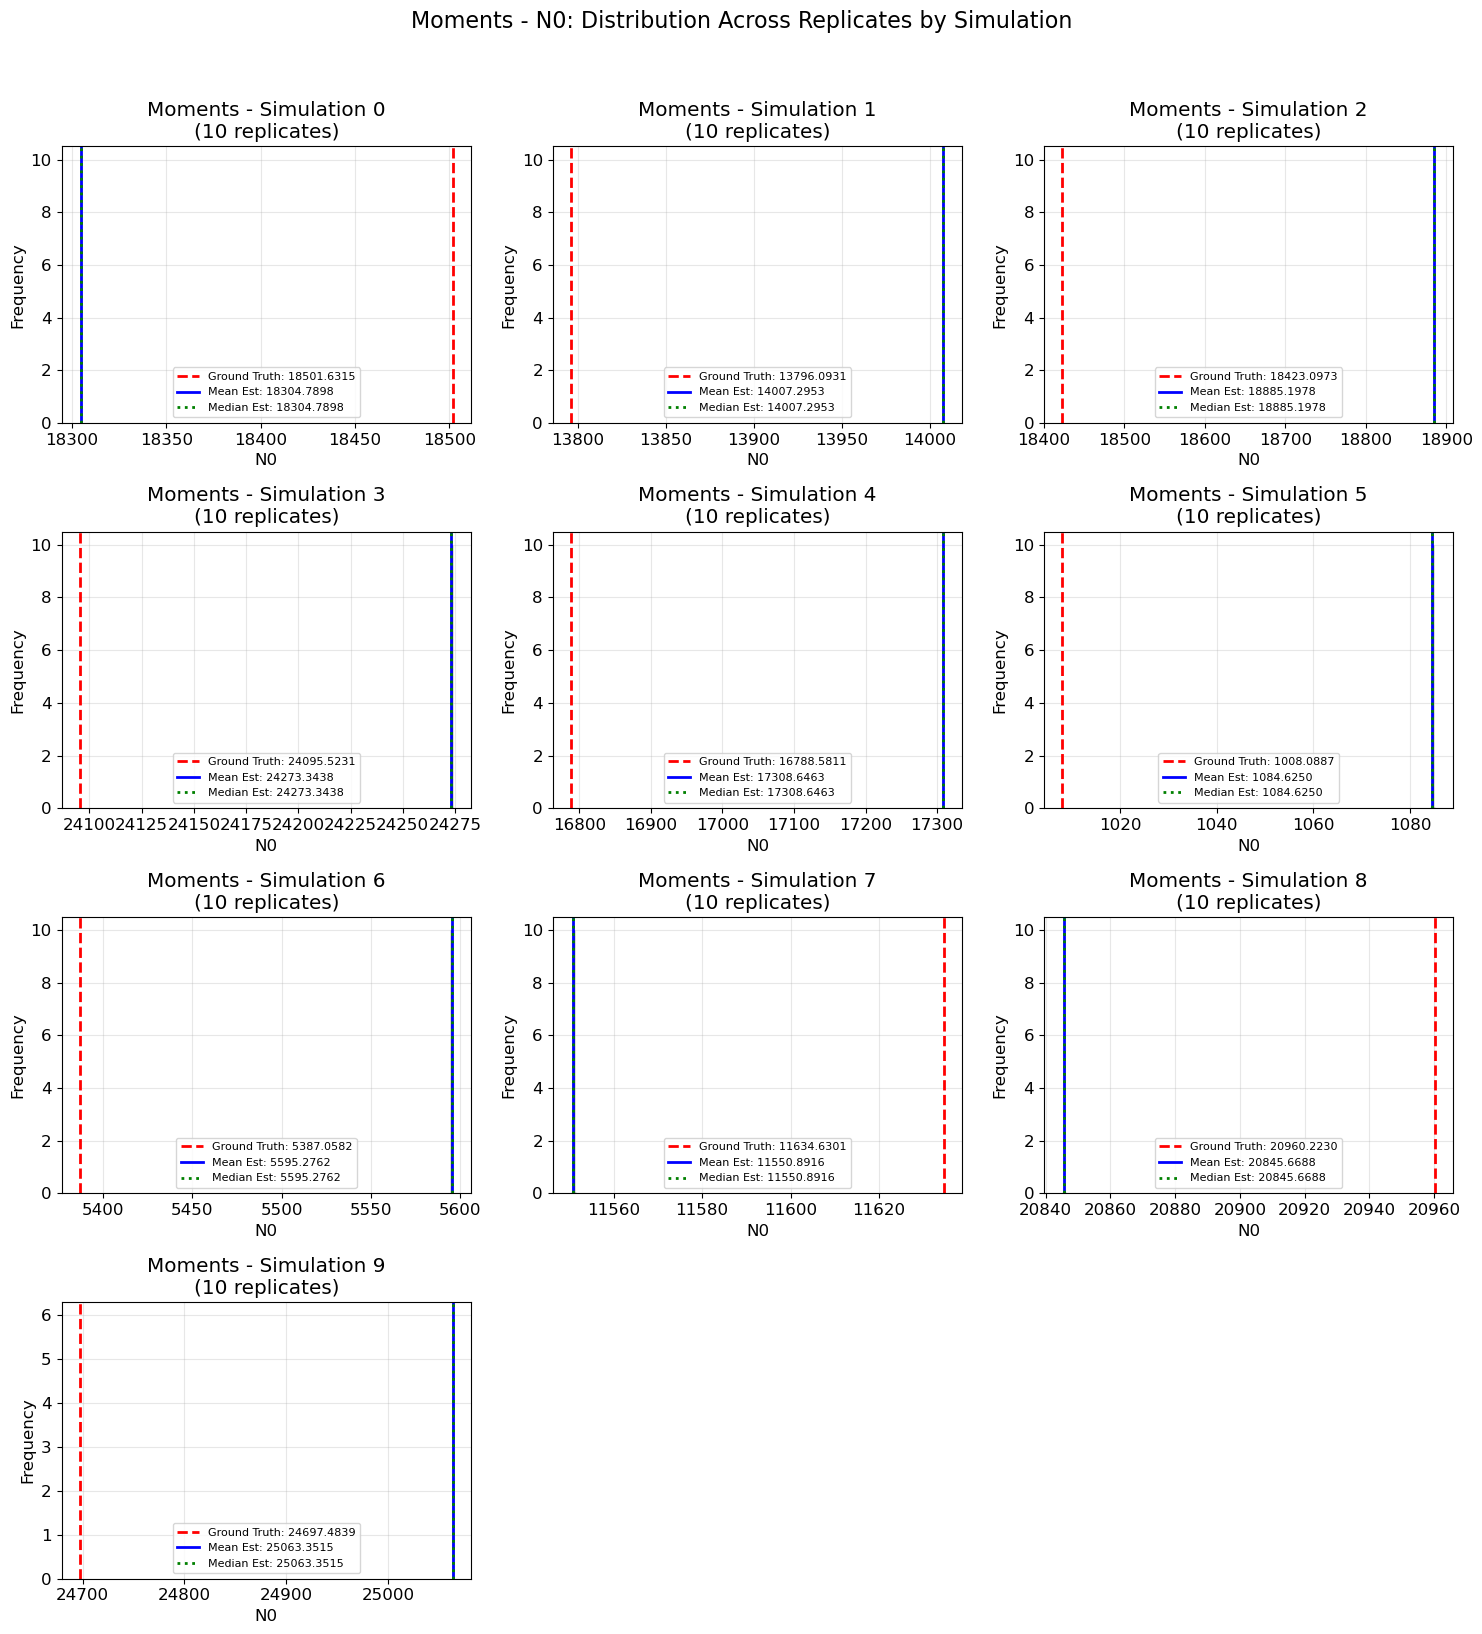

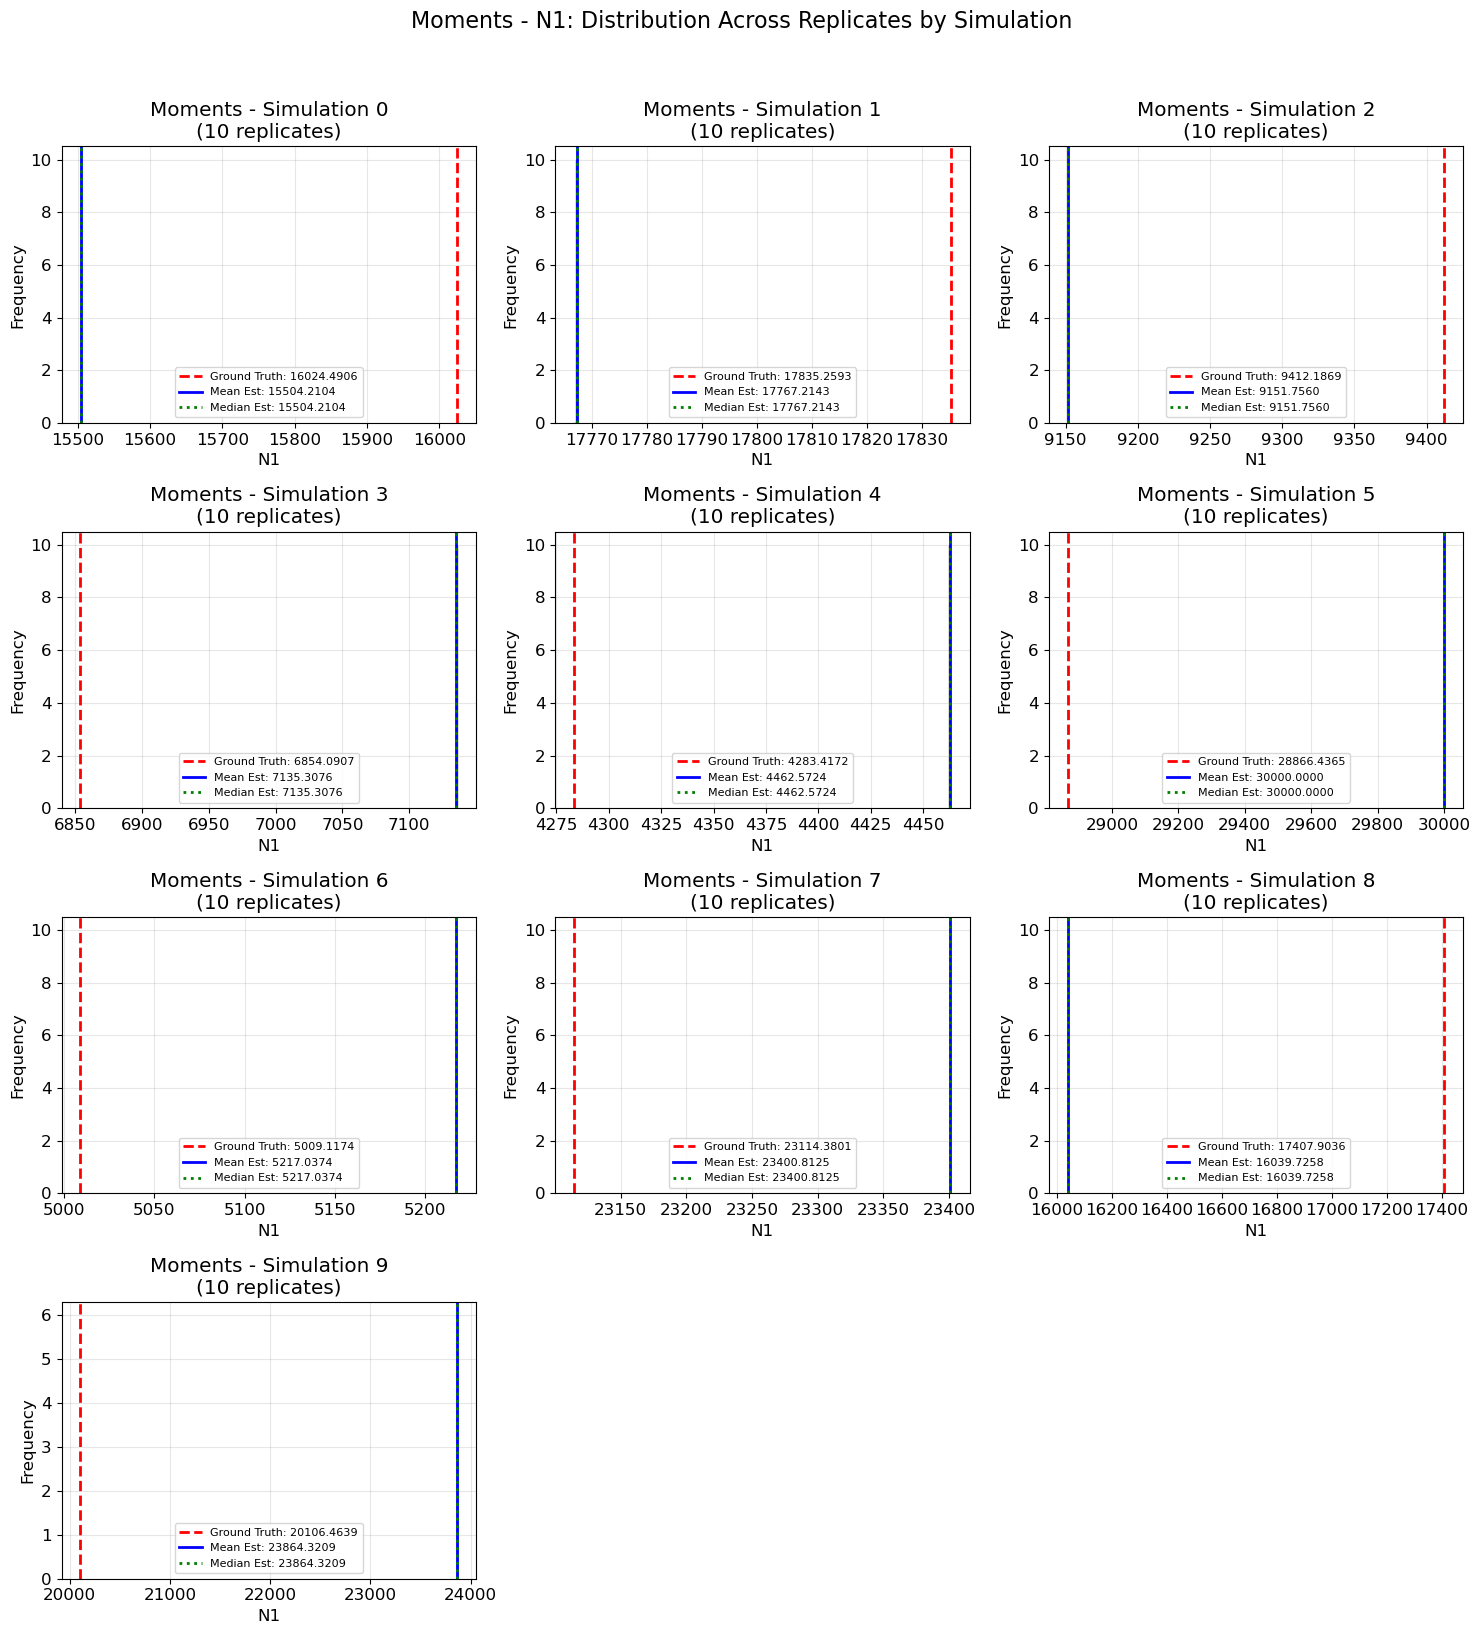

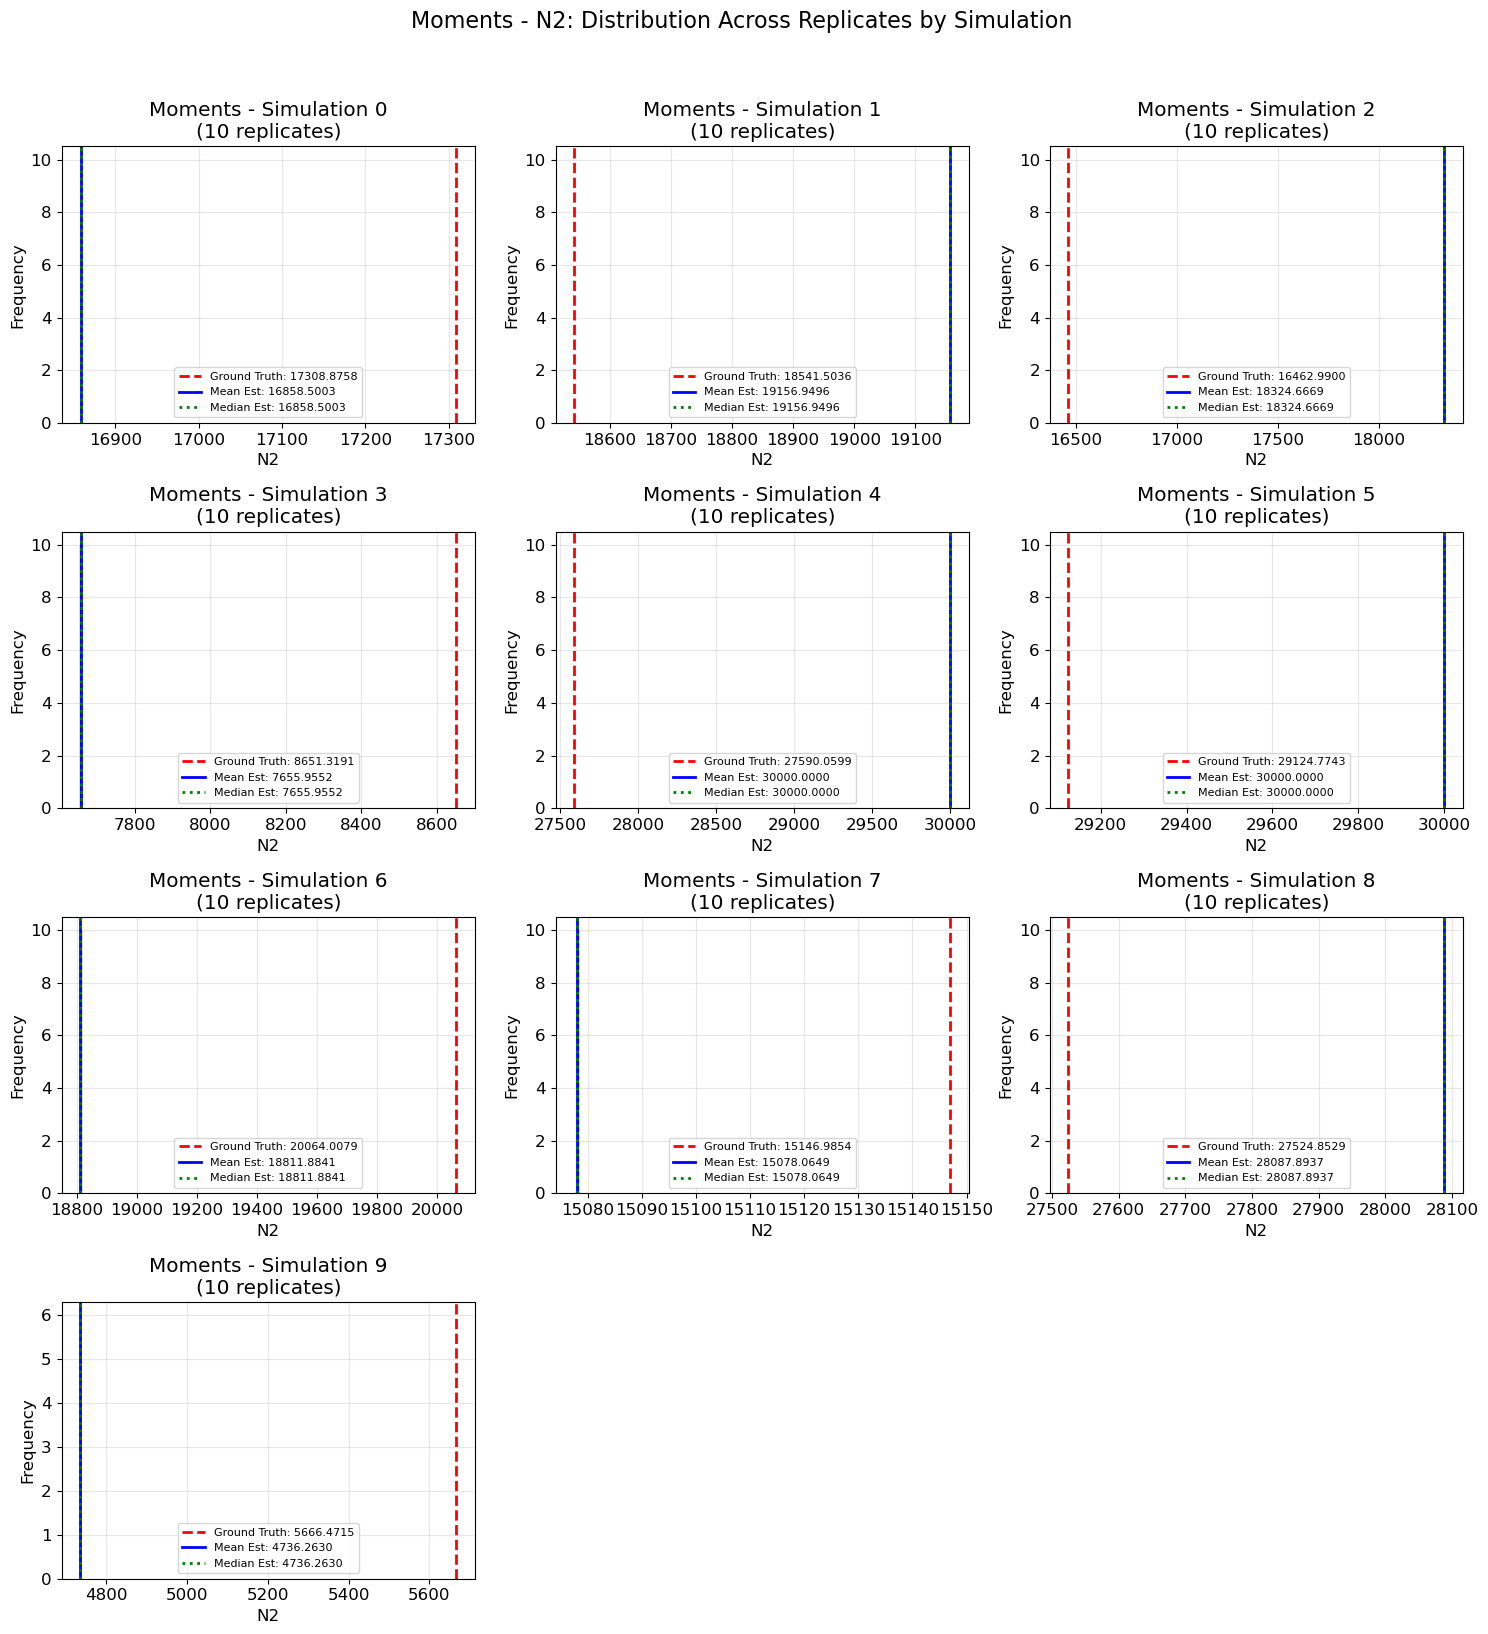

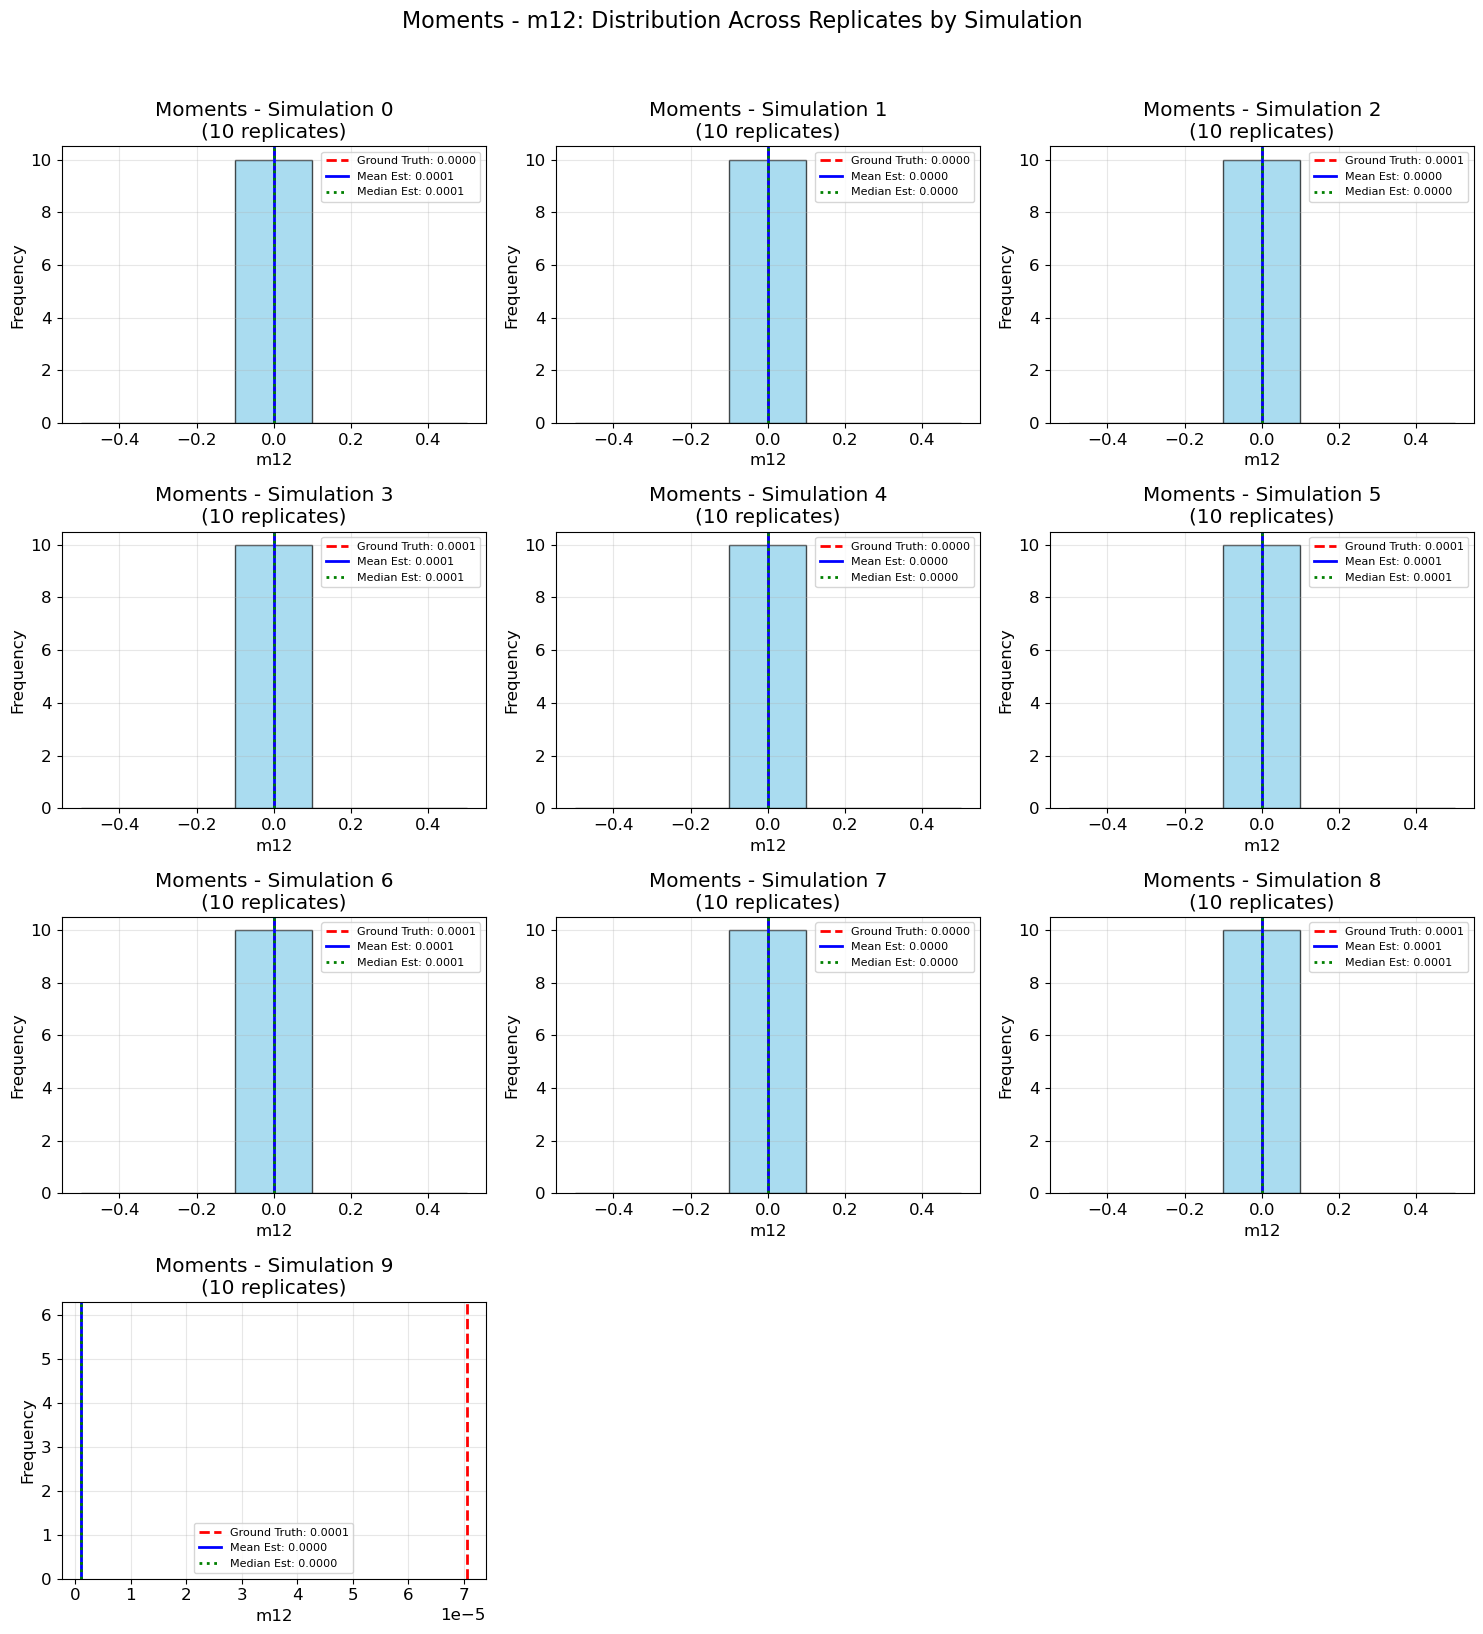

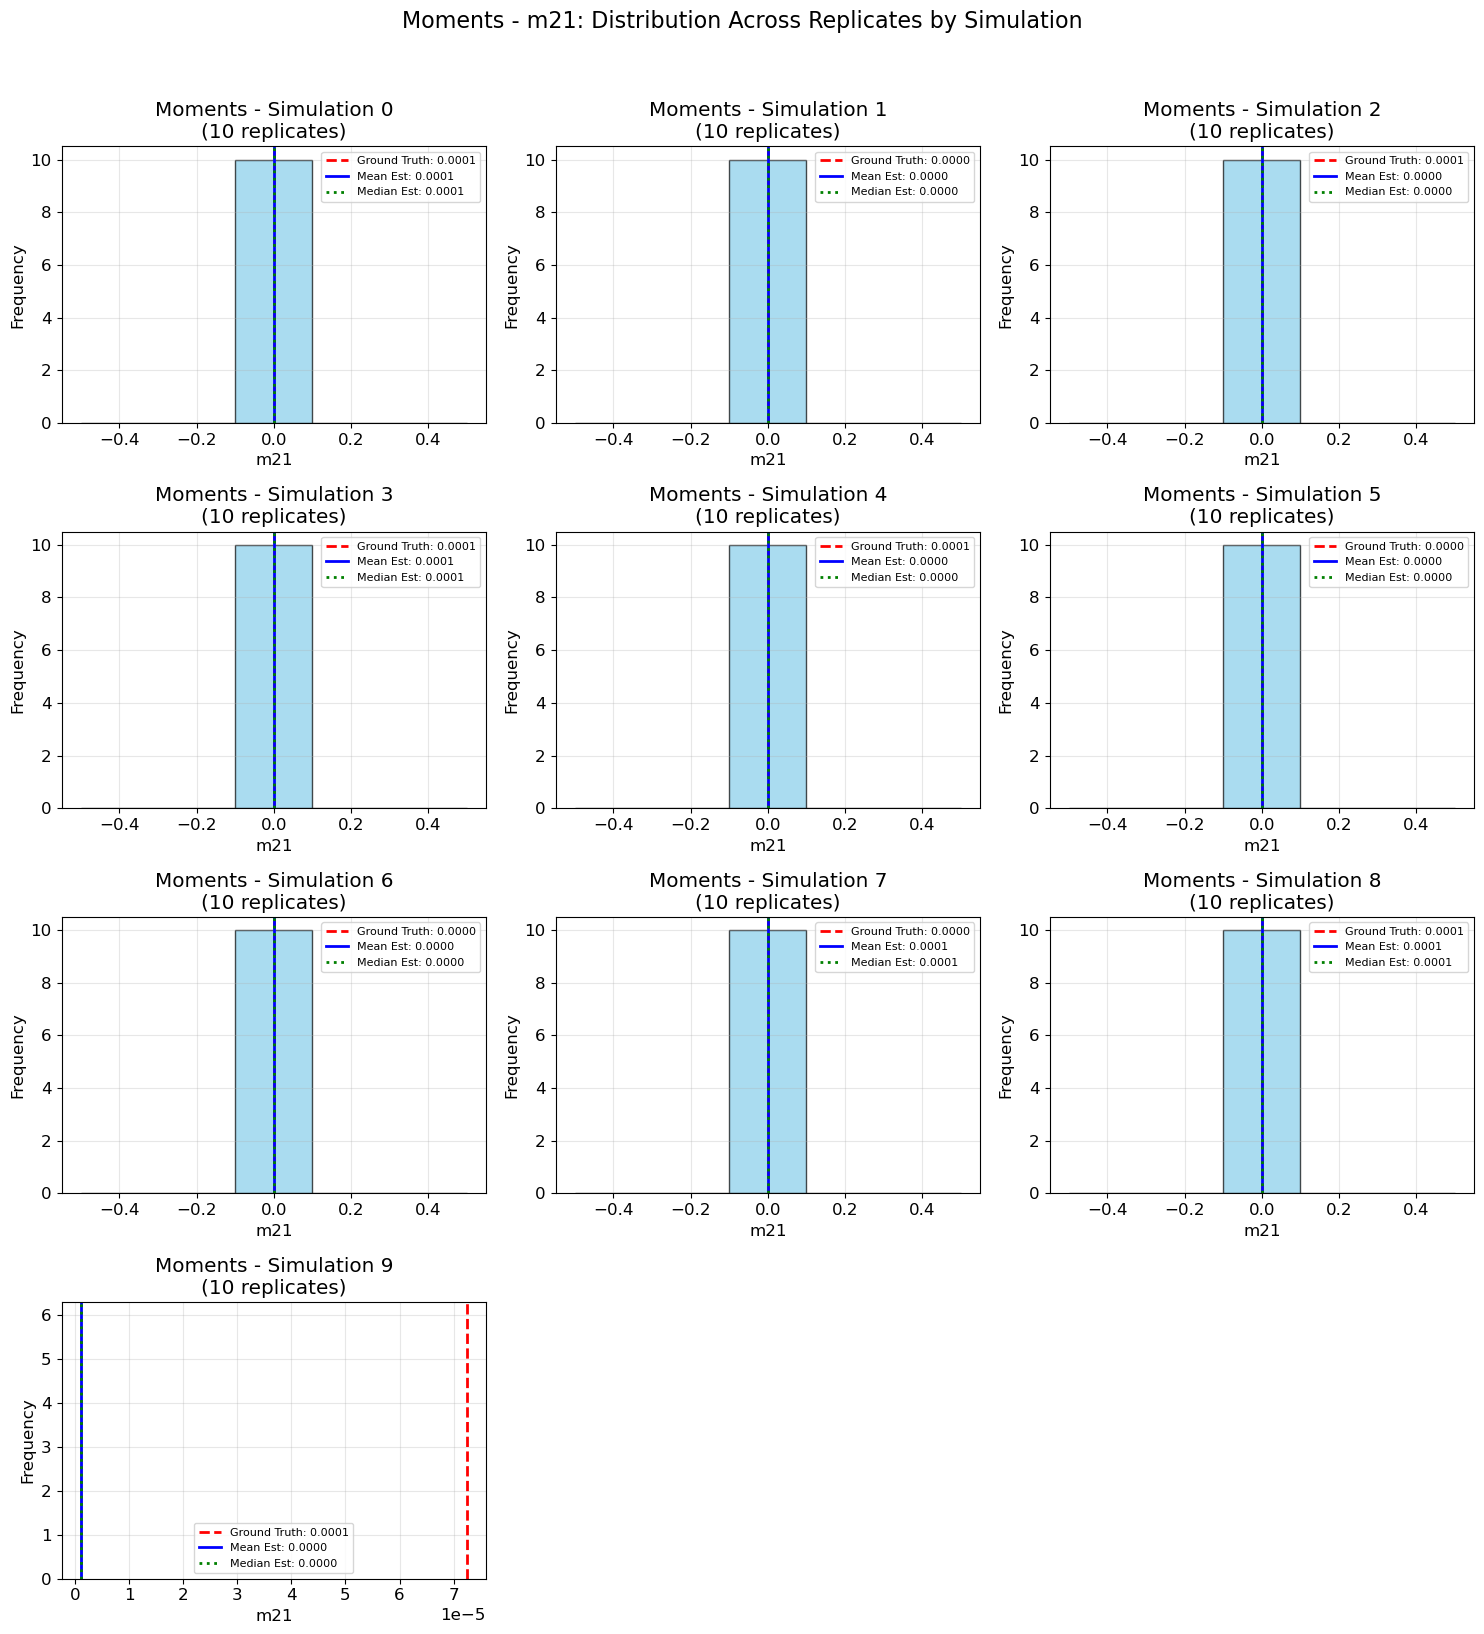

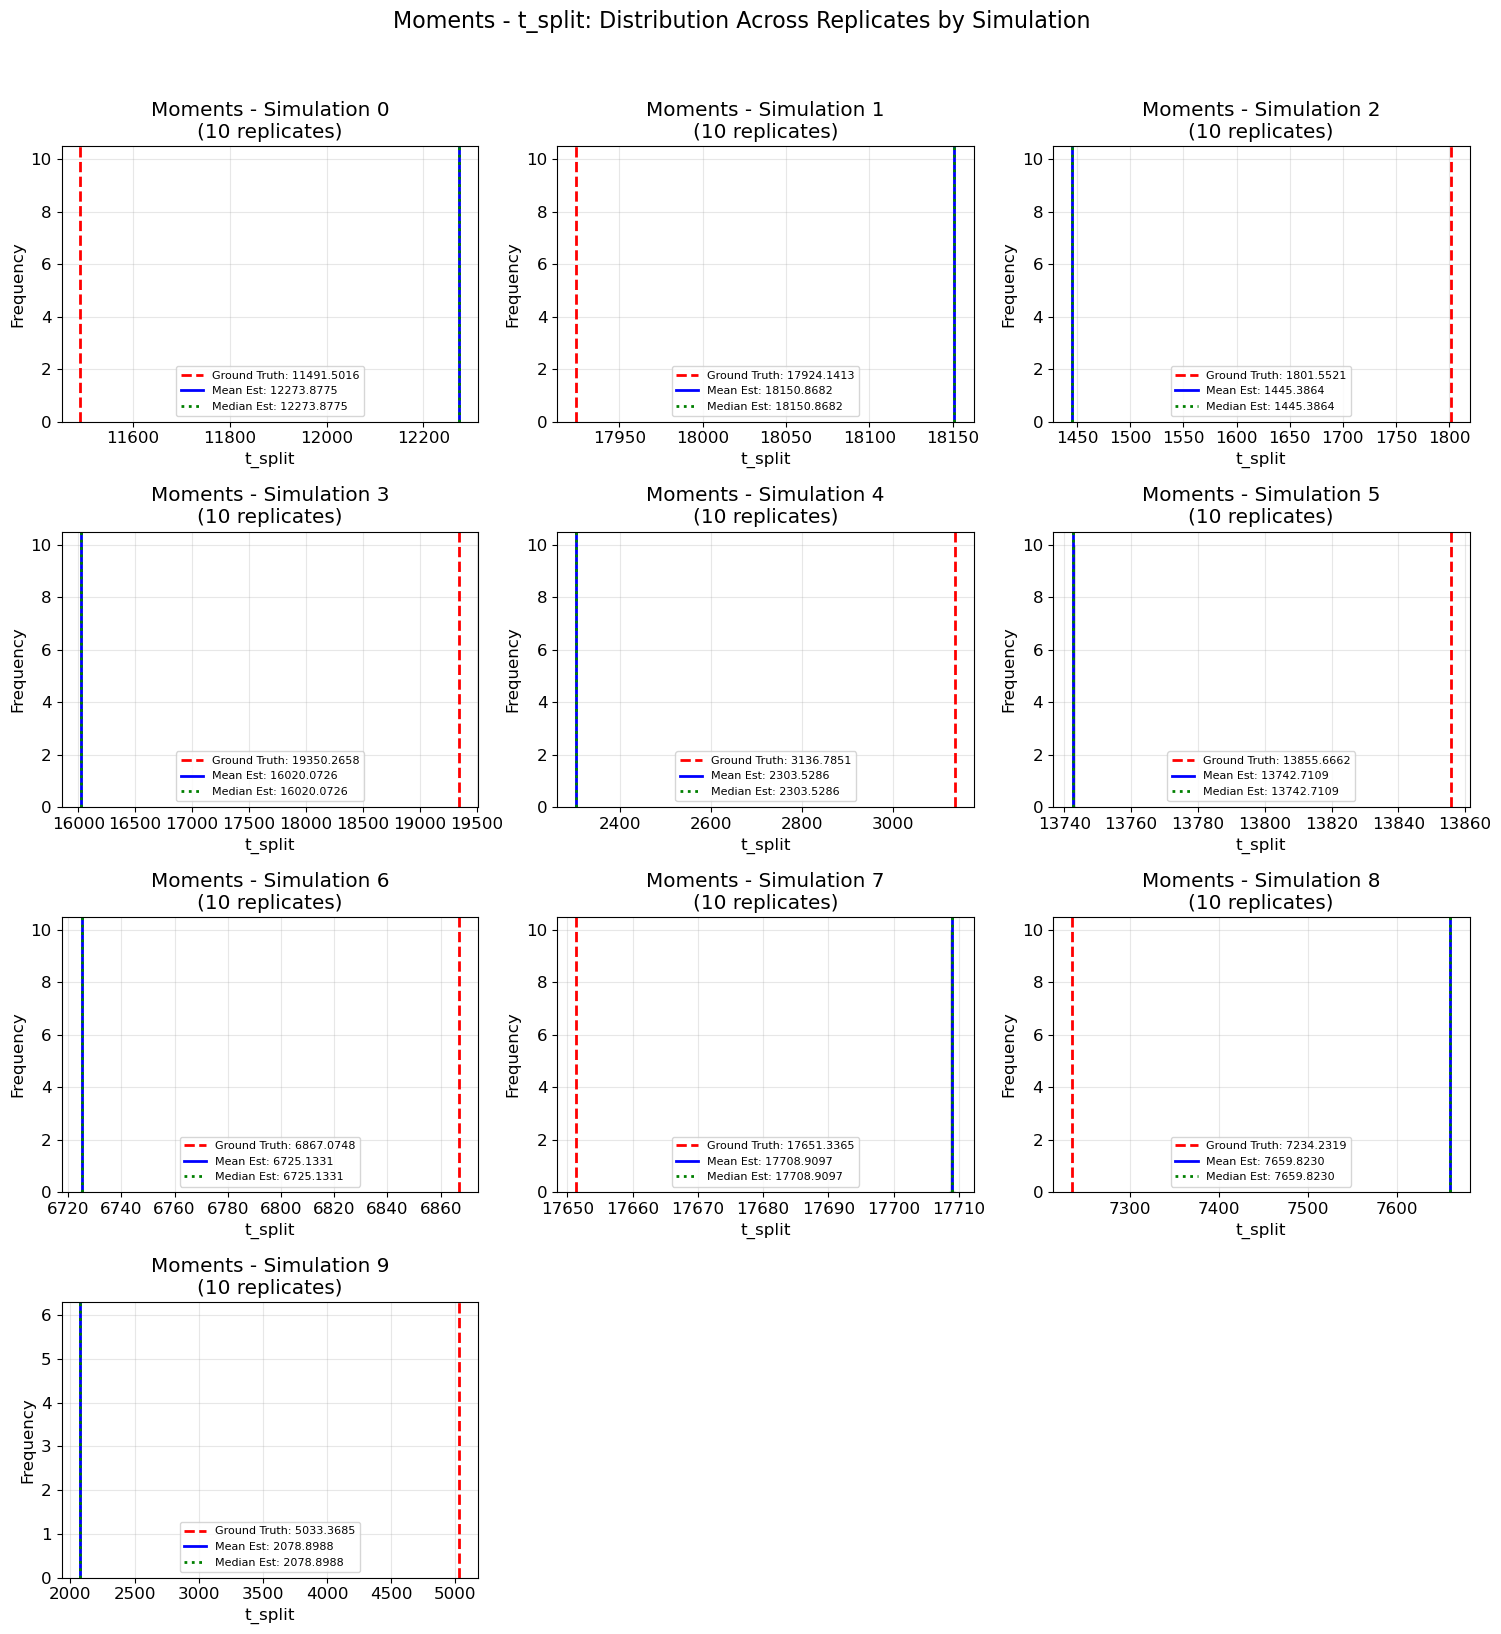

In [8]:
def plot_moments_parameter_histograms_by_simulation(df, parameter_name):
    """Plot histograms of estimated parameters for each simulation (moments)."""
    param_data = df[(df['parameter'] == parameter_name) & (df['parameter'] != 'log_likelihood')]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return
    
    simulations = sorted(param_data['simulation'].unique())
    n_sims = len(simulations)
    
    if n_sims == 0:
        print(f"No simulations found for parameter {parameter_name}")
        return
    
    # Create subplots
    cols = min(3, n_sims)
    rows = (n_sims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, sim_id in enumerate(simulations):
        row = i // cols
        col = i % cols
        
        if rows == 1 and cols == 1:
            ax = axes[0]
        elif rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        
        sim_data = param_data[param_data['simulation'] == sim_id]
        
        if len(sim_data) == 0:
            ax.set_visible(False)
            continue
        
        # Plot histogram
        estimates = sim_data['estimated'].dropna()
        if len(estimates) > 0:
            bins = min(10, max(3, len(estimates) // 2))
            ax.hist(estimates, bins=bins, alpha=0.7, edgecolor='black', color='skyblue')
            
            # Add vertical line for ground truth
            gt_value = sim_data['ground_truth'].iloc[0]
            ax.axvline(gt_value, color='red', linestyle='--', linewidth=2, 
                      label=f'Ground Truth: {gt_value:.4f}')
            
            # Add vertical line for mean estimate
            mean_est = estimates.mean()
            ax.axvline(mean_est, color='blue', linestyle='-', linewidth=2,
                      label=f'Mean Est: {mean_est:.4f}')
            
            # Add vertical line for median estimate
            median_est = estimates.median()
            ax.axvline(median_est, color='green', linestyle=':', linewidth=2,
                      label=f'Median Est: {median_est:.4f}')
        
        ax.set_title(f'Moments - Simulation {sim_id}\n({len(estimates)} replicates)')
        ax.set_xlabel(f'{parameter_name}')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_sims, rows * cols):
        row = i // cols
        col = i % cols
        if rows == 1:
            axes[0, col].set_visible(False)
        elif cols == 1:
            axes[row, 0].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    plt.suptitle(f'Moments - {parameter_name}: Distribution Across Replicates by Simulation', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Create histograms for all parameters (excluding log_likelihood)
if 'df_moments_comparison' in locals() and not df_moments_comparison.empty:
    params_to_plot = [p for p in df_moments_comparison['parameter'].unique() if p != 'log_likelihood']
    
    for param in params_to_plot:
        plot_moments_parameter_histograms_by_simulation(df_moments_comparison, param)
else:
    print("No moments comparison data available for plotting")

## Statistical Analysis of Moments Parameter Estimates

Calculate summary statistics and assess bias and accuracy relative to ground truth.

Moments Parameter Estimation Statistics:
   parameter simulation  ground_truth  mean_estimate  relative_bias  \
0         N0          0    18501.6315     18304.7898        -0.0106   
1         N0          1    13796.0931     14007.2953         0.0153   
2         N0          2    18423.0973     18885.1978         0.0251   
3         N0          3    24095.5231     24273.3438         0.0074   
4         N0          4    16788.5811     17308.6463         0.0310   
5         N0          5     1008.0887      1084.6250         0.0759   
6         N0          6     5387.0582      5595.2762         0.0387   
7         N0          7    11634.6301     11550.8916        -0.0072   
8         N0          8    20960.2230     20845.6688        -0.0055   
9         N0          9    24697.4839     25063.3515         0.0148   
10        N1          0    16024.4906     15504.2104        -0.0325   
11        N1          1    17835.2593     17767.2143        -0.0038   
12        N1          2     9412.186

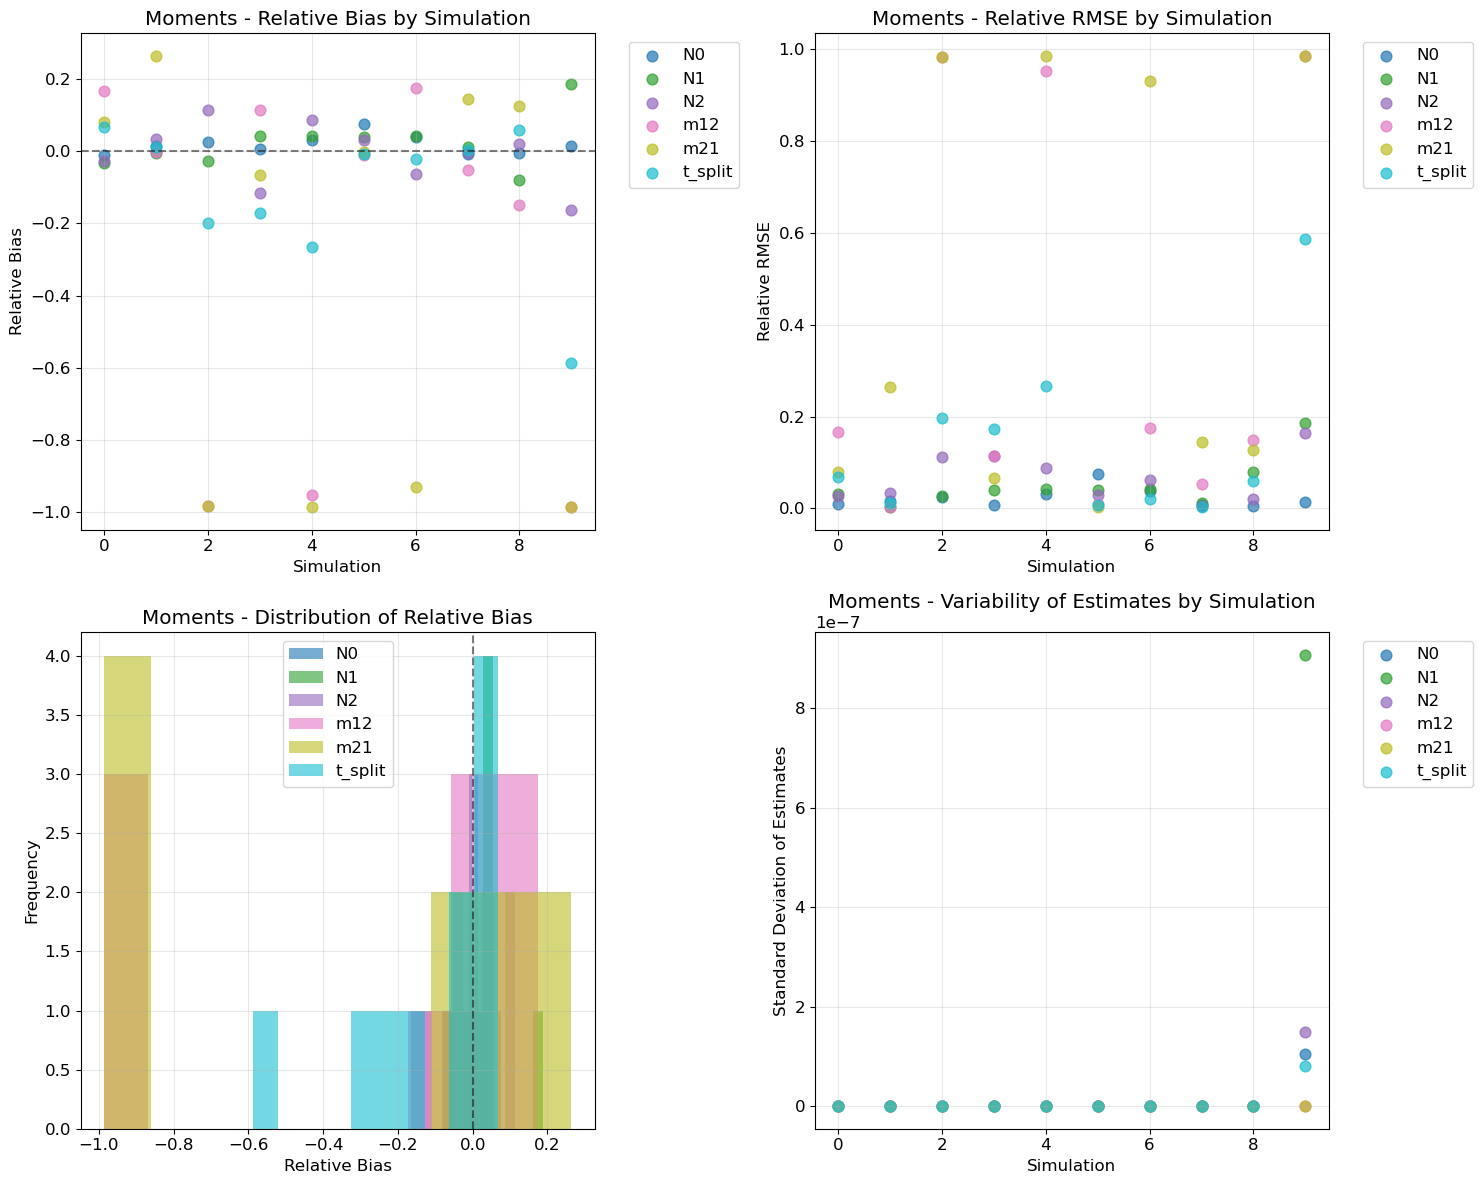



Moments - Overall Summary by Parameter:
          relative_bias                 relative_rmse                  \
                   mean     std  median          mean     std  median   
parameter                                                               
N0               0.0185  0.0261  0.0151        0.0231  0.0216  0.0151   
N1               0.0220  0.0707  0.0258        0.0505  0.0519  0.0401   
N2              -0.0088  0.0862  0.0080        0.0656  0.0522  0.0478   
m12             -0.2684  0.4969 -0.0315        0.3592  0.4285  0.1578   
m21             -0.3338  0.5555 -0.0346        0.4569  0.4477  0.2043   
t_split         -0.1108  0.2027 -0.0144        0.1394  0.1820  0.0635   

          relative_mae                 n_replicates  
                  mean     std  median          sum  
parameter                                            
N0              0.0231  0.0216  0.0151          100  
N1              0.0505  0.0519  0.0401          100  
N2              0.0656  0.0522

In [9]:
def calculate_moments_parameter_statistics(df):
    """Calculate comprehensive statistics for moments parameter estimates."""
    stats_results = []
    
    # Exclude log_likelihood from analysis
    param_df = df[df['parameter'] != 'log_likelihood']
    
    for param in param_df['parameter'].unique():
        param_data = param_df[param_df['parameter'] == param]
        
        for sim_id in param_data['simulation'].unique():
            sim_data = param_data[param_data['simulation'] == sim_id]
            
            # Remove NaN values
            valid_data = sim_data.dropna(subset=['ground_truth', 'estimated'])
            
            if len(valid_data) == 0:
                continue
                
            gt_value = valid_data['ground_truth'].iloc[0]
            estimates = valid_data['estimated']
            
            # Calculate statistics
            stats_results.append({
                'parameter': param,
                'simulation': sim_id,
                'ground_truth': gt_value,
                'mean_estimate': estimates.mean(),
                'median_estimate': estimates.median(),
                'std_estimate': estimates.std(),
                'min_estimate': estimates.min(),
                'max_estimate': estimates.max(),
                'q25_estimate': estimates.quantile(0.25),
                'q75_estimate': estimates.quantile(0.75),
                'bias': estimates.mean() - gt_value,
                'relative_bias': (estimates.mean() - gt_value) / gt_value if gt_value != 0 else np.nan,
                'abs_bias': abs(estimates.mean() - gt_value),
                'rmse': np.sqrt(((estimates - gt_value) ** 2).mean()),
                'relative_rmse': np.sqrt(((estimates - gt_value) ** 2).mean()) / abs(gt_value) if gt_value != 0 else np.nan,
                'mae': np.mean(np.abs(estimates - gt_value)),
                'relative_mae': np.mean(np.abs(estimates - gt_value)) / abs(gt_value) if gt_value != 0 else np.nan,
                'n_replicates': len(estimates)
            })
    
    return pd.DataFrame(stats_results)

def plot_moments_bias_analysis(stats_df):
    """Plot bias analysis for moments results across parameters and simulations."""
    if stats_df.empty:
        print("No statistics data available for plotting")
        return
        
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Relative bias by parameter and simulation
    ax1 = axes[0, 0]
    colors = plt.cm.tab10(np.linspace(0, 1, len(stats_df['parameter'].unique())))
    for i, param in enumerate(stats_df['parameter'].unique()):
        param_stats = stats_df[stats_df['parameter'] == param]
        ax1.scatter(param_stats['simulation'].astype(int), param_stats['relative_bias'], 
                   label=param, alpha=0.7, s=60, color=colors[i])
    ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Relative Bias')
    ax1.set_title('Moments - Relative Bias by Simulation')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Relative RMSE by parameter and simulation
    ax2 = axes[0, 1]
    for i, param in enumerate(stats_df['parameter'].unique()):
        param_stats = stats_df[stats_df['parameter'] == param]
        ax2.scatter(param_stats['simulation'].astype(int), param_stats['relative_rmse'], 
                   label=param, alpha=0.7, s=60, color=colors[i])
    ax2.set_xlabel('Simulation')
    ax2.set_ylabel('Relative RMSE')
    ax2.set_title('Moments - Relative RMSE by Simulation')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Overall bias distribution
    ax3 = axes[1, 0]
    for i, param in enumerate(stats_df['parameter'].unique()):
        param_stats = stats_df[stats_df['parameter'] == param]
        valid_bias = param_stats['relative_bias'].dropna()
        if len(valid_bias) > 0:
            ax3.hist(valid_bias, alpha=0.6, label=param, bins=10, color=colors[i])
    ax3.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Relative Bias')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Moments - Distribution of Relative Bias')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Standard deviation of estimates
    ax4 = axes[1, 1]
    for i, param in enumerate(stats_df['parameter'].unique()):
        param_stats = stats_df[stats_df['parameter'] == param]
        ax4.scatter(param_stats['simulation'].astype(int), param_stats['std_estimate'], 
                   label=param, alpha=0.7, s=60, color=colors[i])
    ax4.set_xlabel('Simulation')
    ax4.set_ylabel('Standard Deviation of Estimates')
    ax4.set_title('Moments - Variability of Estimates by Simulation')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Calculate and display statistics for moments
if 'df_moments_comparison' in locals() and not df_moments_comparison.empty:
    moments_stats_df = calculate_moments_parameter_statistics(df_moments_comparison)
    
    print("Moments Parameter Estimation Statistics:")
    print("=" * 60)
    
    if not moments_stats_df.empty:
        # Display summary table
        summary_cols = ['parameter', 'simulation', 'ground_truth', 'mean_estimate', 
                       'relative_bias', 'relative_rmse', 'n_replicates']
        print(moments_stats_df[summary_cols].round(4))
        
        # Plot bias analysis
        plot_moments_bias_analysis(moments_stats_df)
        
        # Overall summary by parameter
        print("\n\nMoments - Overall Summary by Parameter:")
        print("=" * 50)
        overall_summary = moments_stats_df.groupby('parameter').agg({
            'relative_bias': ['mean', 'std', 'median'],
            'relative_rmse': ['mean', 'std', 'median'],
            'relative_mae': ['mean', 'std', 'median'],
            'n_replicates': 'sum'
        }).round(4)
        print(overall_summary)
    else:
        print("No valid statistics calculated")
        
else:
    print("No moments comparison data available for statistical analysis")

## Likelihood Analysis for Moments

Analyze the likelihood values achieved by moments optimization.

Moments Likelihood Analysis:

Likelihood summary by simulation:
            N_reps      Mean_LL    Median_LL  Std_LL       Min_LL       Max_LL
simulation                                                                    
0               10  349895.6869  349895.6869     0.0  349895.6869  349895.6869
1               10  371590.0782  371590.0782     0.0  371590.0782  371590.0782
2               10  268855.0418  268855.0418     0.0  268855.0418  268855.0418
3               10  237515.3609  237515.3609     0.0  237515.3609  237515.3609
4               10  250343.5050  250343.5050     0.0  250343.5050  250343.5050
5               10  331500.7614  331500.7614     0.0  331500.7614  331500.7614
6               10  153110.9589  153110.9589     0.0  153110.9589  153110.9589
7               10  352732.6248  352732.6248     0.0  352732.6248  352732.6248
8               10  400869.3154  400869.3154     0.0  400869.3154  400869.3154
9               10  340028.7555  340028.7555     0.0  340028.7555  

/tmp/ipykernel_640289/1981906068.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(ll_by_sim, labels=simulations, patch_artist=True)


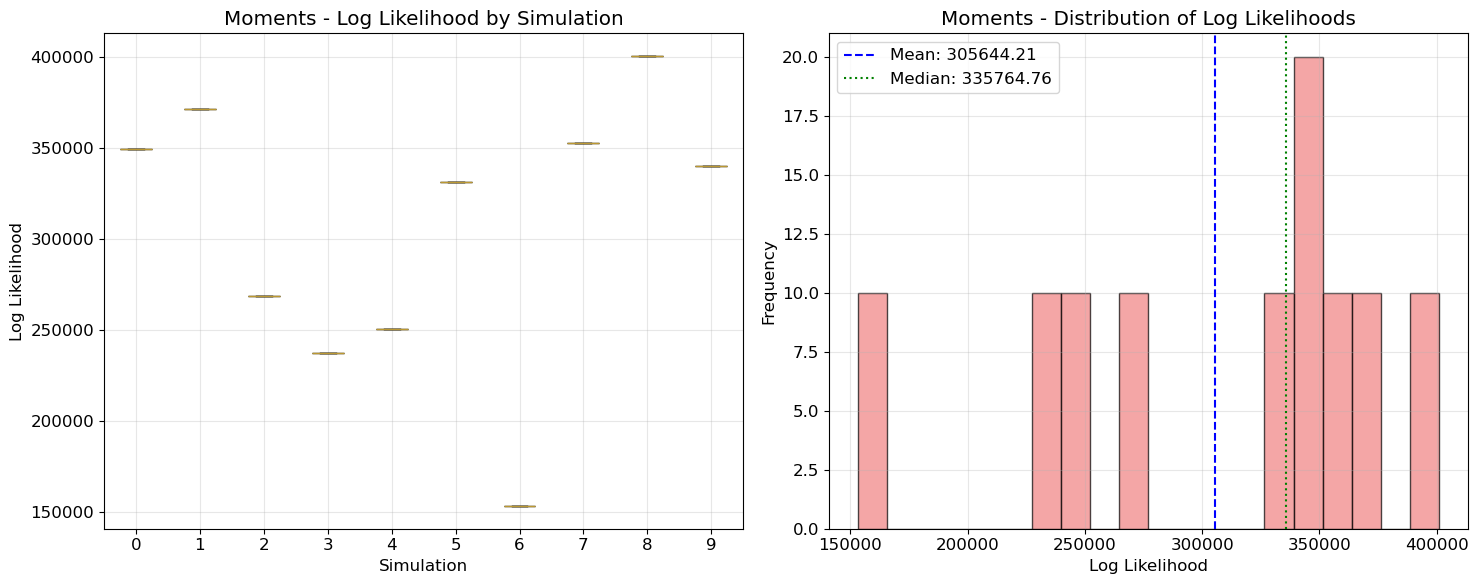


Overall likelihood statistics:
  Total estimates: 100
  Mean: 305644.2089
  Median: 335764.7584
  Std: 72308.6762
  Range: [153110.9589, 400869.3154]


In [10]:
def analyze_moments_likelihoods(df):
    """Analyze likelihood values from moments optimization."""
    ll_data = df[df['parameter'] == 'log_likelihood']
    
    if ll_data.empty:
        print("No likelihood data found in moments results")
        return
    
    print("Moments Likelihood Analysis:")
    print("=" * 40)
    
    # Summary statistics by simulation
    ll_summary = ll_data.groupby('simulation')['estimated'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(4)
    ll_summary.columns = ['N_reps', 'Mean_LL', 'Median_LL', 'Std_LL', 'Min_LL', 'Max_LL']
    print("\nLikelihood summary by simulation:")
    print(ll_summary)
    
    # Plot likelihood distributions
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot by simulation
    ax1 = axes[0]
    simulations = sorted(ll_data['simulation'].unique())
    ll_by_sim = [ll_data[ll_data['simulation'] == sim]['estimated'].values for sim in simulations]
    
    bp = ax1.boxplot(ll_by_sim, labels=simulations, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Log Likelihood')
    ax1.set_title('Moments - Log Likelihood by Simulation')
    ax1.grid(True, alpha=0.3)
    
    # Overall histogram
    ax2 = axes[1]
    ax2.hist(ll_data['estimated'], bins=20, alpha=0.7, edgecolor='black', color='lightcoral')
    ax2.axvline(ll_data['estimated'].mean(), color='blue', linestyle='--', 
               label=f'Mean: {ll_data["estimated"].mean():.2f}')
    ax2.axvline(ll_data['estimated'].median(), color='green', linestyle=':', 
               label=f'Median: {ll_data["estimated"].median():.2f}')
    ax2.set_xlabel('Log Likelihood')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Moments - Distribution of Log Likelihoods')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Overall statistics
    print(f"\nOverall likelihood statistics:")
    print(f"  Total estimates: {len(ll_data)}")
    print(f"  Mean: {ll_data['estimated'].mean():.4f}")
    print(f"  Median: {ll_data['estimated'].median():.4f}")
    print(f"  Std: {ll_data['estimated'].std():.4f}")
    print(f"  Range: [{ll_data['estimated'].min():.4f}, {ll_data['estimated'].max():.4f}]")

# Analyze likelihoods if available
if 'df_moments_comparison' in locals() and not df_moments_comparison.empty:
    analyze_moments_likelihoods(df_moments_comparison)
else:
    print("No moments comparison data available for likelihood analysis")

## Save Moments Results

Save the comparison data and statistics for future reference.

In [ ]:
# Save results to CSV files
output_dir = Path('/home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results')
output_dir.mkdir(exist_ok=True)

if 'df_moments_comparison' in locals() and not df_moments_comparison.empty:
    # Save comparison data
    comparison_file = output_dir / 'moments_parameter_comparison.csv'
    df_moments_comparison.to_csv(comparison_file, index=False)
    print(f"Saved moments comparison data to: {comparison_file}")
    
    # Save statistics
    if 'moments_stats_df' in locals() and not moments_stats_df.empty:
        stats_file = output_dir / 'moments_parameter_statistics.csv'
        moments_stats_df.to_csv(stats_file, index=False)
        print(f"Saved moments statistics to: {stats_file}")
    
    # Create a summary comparison file
    summary_file = output_dir / 'moments_analysis_summary.txt'
    with open(summary_file, 'w') as f:
        f.write("Moments Parameter Analysis Summary\n")
        f.write("=" * 40 + "\n\n")
        
        f.write(f"Total parameter estimates: {len(df_moments_comparison)}\n")
        f.write(f"Parameters analyzed: {list(df_moments_comparison['parameter'].unique())}\n")
        f.write(f"Simulations: {sorted(df_moments_comparison['simulation'].unique())}\n")
        
        if 'moments_stats_df' in locals() and not moments_stats_df.empty:
            f.write("\nParameter-wise summary:\n")
            for param in moments_stats_df['parameter'].unique():
                param_data = moments_stats_df[moments_stats_df['parameter'] == param]
                mean_bias = param_data['relative_bias'].mean()
                mean_rmse = param_data['relative_rmse'].mean()
                f.write(f"  {param}: Mean rel. bias = {mean_bias:.4f}, Mean rel. RMSE = {mean_rmse:.4f}\n")
    
    print(f"Saved moments analysis summary to: {summary_file}")
    print(f"\nMoments analysis complete! Results saved to {output_dir}")
else:
    print("No moments data to save - check data loading steps above")